# 1 - Preparação dos dados

O presente estudo se propõe a analisar a duração de processos que tramitam ou tramitaram perante órgãos julgadores de primeira instância, distribuídos na Comarca de Campina Grande a partir de 1º de janeiro de 2016, **excluídos os de natureza criminal e aqueles em segredo de justiça**. A análise será feita a partir dos dados de movimentações processuais do período que se estende até a extração da base (em 11/01/2022), obtidos em requerimento fundamentado na Lei de Acesso à Informação (Lei nº 15.527/2011).

## 1.1 - Leitura dos dados

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, MultipleLocator, FormatStrFormatter
import seaborn as sns


import re
import numpy as np

In [2]:
procs = pd.read_csv('PA_2021124355_.csv',
                    encoding='utf-8-sig')
# renomeia colunas
procs.columns = ['desc', 'timestamp',
                 'id_processo', 'classe', 'assunto', 'org_julg',
                 'comp', 'comarca', 'valor_causa', 'status']
procs['timestamp'] = pd.to_datetime(procs['timestamp'])

# ordena por data da movimentação
procs = procs.sort_values(by='timestamp')
procs.head()

print(procs.shape)

(4136310, 10)


**Dados iniciais**

In [3]:
procs.nunique()

desc            545864
timestamp      3846998
id_processo     119098
classe             142
assunto            982
org_julg            42
comp                22
comarca              1
valor_causa      41936
status               2
dtype: int64

Inicialmente, tem-se 119.098 processos, com 142 classes, 982 assuntos e 42 órgãos julgadores diferentes.

## 1.2 - Limpeza da base

Primeiro, **são removidos os processos oriundos de varas criminais**, uma vez que estão fora do escopo proposto para este trabalho.

In [4]:
# lista varas criminais
orgaos_criminais = [orgao for orgao in procs['org_julg'].unique(
) if re.search('crim|entorp|júri|violência', orgao, flags=re.I)]
print(orgaos_criminais)

['1ª Vara Criminal de Campina Grande', '2ª Vara Criminal de Campina Grande', '2ª Vara do Tribunal do Júri de Campina Grande', 'Juizado de Violência Doméstica e Familiar contra a Mulher de Campina Grande', '4ª Vara Criminal de Campina Grande', '5ª Vara Criminal de Campina Grande', '1ª Vara do Tribunal do Júri de Campina Grande', '3ª Vara Criminal de Campina Grande', 'Juizado Especial Criminal de Campina Grande', 'Vara de Entorpecentes de Campina Grande']


In [5]:
# remove processos criminais
procs = procs[~procs['org_julg'].isin(orgaos_criminais)]

No mesmo sentido, é examinada a coluna relativa competência, para a remoção de procedimentos penais.

Além disso, removem-se aqueles processos que incluem os termos "PROCON" ou "CEJUSC", os quais entendemos que, apesar de tramitarem no sistema PJe, estão relacionados a tratativas de autocomposição de conflitos.

In [6]:
comps_criminais = ['Juizado Especial Criminal (Art. 201 - LOJE)', 'Tribunal do Juri (Art. 176 LOJE)', 'Criminal (Art. 175 LOJE)']
procs = procs[~procs['comp'].isin(comps_criminais)]

procs = procs[~procs['comp'].str.contains('procon|cejusc',flags=re.I)]

Abaixo, é ajustada a coluna de descrição das movimentações, substituindo caracteres estranhos por inconsistências no encoding.

In [7]:
# Limpeza da descrição — Inconsistências de encoding
procs['desc'] = (
    procs['desc']
    .str.replace('Ãª', 'ê', regex=False)
    .str.replace('Ã§', 'ç', regex=False)
    .str.replace('Ã£', 'ã', regex=False)
)


In [8]:
pos_limpeza = procs.nunique()  # .to_dict()
procs_unicos, orgaos_julgadores = pos_limpeza[['id_processo', 'org_julg']]
print(f"""\
Após filtragem e limpeza, temos uma base com {procs.shape[0]} movimentações, de {procs_unicos} processos distintos,
de {orgaos_julgadores} órgãos julgadores diferentes.""")


Após filtragem e limpeza, temos uma base com 3369582 movimentações, de 99982 processos distintos,
de 27 órgãos julgadores diferentes.


In [9]:
# TODO: Definir
classes_remover =[
    'TUTELA ANTECIPADA ANTECEDENTE',
    'TUTELA CAUTELAR ANTECEDENTE',
]

In [10]:
procs['comp'].unique()

array(['Fazenda Pública (Art. 165 LOJE-PB)',
       'Feitos Especiais (Art. 169 LOJE-PB)', 'Cível (Art. 164 LOJE-PB)',
       'Juizado Especial Cível (Art. 201 LOJE-PB)',
       'Sucessões (Art. 170 LOJE-PB)', 'Infância e Juventude (Civel)',
       'Execução Fiscal Municipal (Art. 166 LOJE-PB)',
       'Execução Fiscal Estadual (Art. 166 LOJE-PB)',
       'Execução Fiscal Federal',
       'Juizado Especial da Fazenda Pública (Lei 12.153/09)'],
      dtype=object)

## 1.3 Tranformação da base
Num primeiro momento, a base de movimentações será transformada de modo a calcular a duração de cada processo.
Examinaremos a coluna *desc* (descrição da movimentação) para verificar quais movimentações marcam o início e o fim de cada processo, havendo este sido finalizado.

### 1.3.1 - Movimento inicial

O movimento inicial do processo é marcado pela distribuição. Na célula abaixo, é filtrado o primeiro movimento listado para cada processo (individualizado pela coluna *id_processo*).
Considerando que a base de dados foi ordenada cronologicamente, o primeiro movimento deveria representar também o início do processo.
Ainda assim, vale realizar esse exame com maior cuidado, para checar a integridade da base de dados.

Abaixo, fazemos uma contagem dos valores mais comuns que preenchem a primeira linha (movimentação) de cada processo.

In [11]:
(    
procs
.groupby('id_processo')
.nth(0)
['desc']
.value_counts()
.head(10)
)

Distribuído por sorteio                                        94906
Distribuído por dependência                                     2200
Juntada de Petição de petição inicial                           2149
Juntada de Petição de petição                                     69
Juntada de Petição de outros documentos                           25
Juntada de Petição de documento de comprovação                    23
Conclusos para despacho                                           16
Mov. [26] - DISTRIBUIDO POR DEPENDENCIA 24: 04/2017 TJECGN7       11
Mov. [26] - DISTRIBUIDO POR DEPENDENCIA 29: 06/2017 TJECGN7       10
Mov. [26] - DISTRIBUIDO POR DEPENDENCIA 17: 10/2017 TJECGDE       10
Name: desc, dtype: int64

Nessa primeira observação, verifica-se que alguns movimentos representam uma mesma categoria, escrita de forma ligeiramente diferente. É o caso de "Mov. [26] - DISTRIBUIDO POR DEPENDENCIA 24: 04/2017 TJECGN7" e "Mov. [26] - DISTRIBUIDO POR DEPENDENCIA 24: 04/2017 TJECGN7", que podemos agrupar simplesmente como Distribuído por dependência.

Outros casos similares foram identificados, e a partir da substituição de texto foi criada uma nova coluna "desc_limpa". Na sequência, se repete a análise acima, dessa vez utilizando a coluna simplificada.

In [12]:
procs ['desc_limpa'] = (
    procs
    ['desc']
    .str.replace('.*DISTRIBUIDO POR DEPENDENCIA.*', 'Distribuído por dependência', regex = True)
    .str.replace('.*DISTRIBUIDO POR SORTEIO.*', 'Distribuído por sorteio', regex = True)
    .str.replace('.*DISTRIBUIDO POR COMPETENCIA EXCLUSIVA.*', 'Distribuído por competência exclusiva', regex = True)
    .str.replace('.*DISTRIBUIDO POR PREVENÇÃO.*', 'Distribuído por prevenção', regex = True)
    .str.replace('.*CONCLUSOS PARA DESPACHO.*', 'Conclusos para despacho', regex = True)
    )



In [13]:
(    
procs
.groupby('id_processo')
.nth(0)
['desc_limpa']
.value_counts()
.head(20)
# .tail(20)
)

Distribuído por sorteio                                     94945
Distribuído por dependência                                  2680
Juntada de Petição de petição inicial                        2149
Juntada de Petição de petição                                  69
Conclusos para despacho                                        49
Juntada de Petição de outros documentos                        25
Juntada de Petição de documento de comprovação                 23
Distribuído por competência exclusiva                           6
Juntada de Petição de procuração                                5
Juntada de Petição de documento recibos salariais               4
Juntada de Petição de comunicações                              4
Juntada de Petição de tomada de termo                           3
Juntada de Petição de carta precatória                          3
Juntada de Petição de exceção de pré-executividade              1
Juntada de petição inicial                                      1
Proferido 

Vê-se que em mais de 97 mil dos quase 100 mil processos sob análise, o primeiro movimento é a relativo à distribuição (conforme esperado). 
Em pouco mais de 2000, a juntada de petição inicial aparece como primeiro movimento.

Apesar disto, quando checamos os valores mais comuns na segunda movimentação de cada processo (abaixo), vemos que 2.167 registram aí a distribuição por sorteio. **Assim, entendemos razoável considerar as linhas relativas à distribuição como marco inicial do processo.**

In [14]:
(    
procs
.groupby('id_processo')
.nth(1)
['desc_limpa']
.value_counts()
.head(20)
)

Conclusos para despacho                                                                                                33891
Conclusos para decisão                                                                                                 25915
Proferido despacho de mero expediente                                                                                   7243
Autos incluídos no Juízo 100% Digital                                                                                   3231
Juntada de Petição de petição                                                                                           2256
Distribuído por sorteio                                                                                                 2166
Juntada de certidão                                                                                                     1126
Ato ordinatório praticado                                                                                                721


Abaixo, criamos uma *"mask"* para marcar essas linhas, e a utilizamos obter um dataframe com a primeira movimentação de cada processo.

In [15]:
movs_distribuicao = ('Distribuído por dependência', 'Distribuído por sorteio',
                     'Distribuído por competência exclusiva', 'Distribuído por prevenção')
mask_primeira_mov =procs['desc_limpa'].isin(movs_distribuicao)
df_primeira_mov = procs[mask_primeira_mov].copy()
df_primeira_mov.shape

(99990, 11)

Vemos que o dataframe resultante contém dez linhas a mais que o esperado. Verifica-se na célula abaixo que são processos (pouquíssimos) nos quais houve redistribuição.

In [16]:
df_primeira_mov[df_primeira_mov['id_processo'].duplicated(keep=False)].sort_values(['id_processo','timestamp'])

,desc,timestamp,id_processo,classe,assunto,org_julg,comp,comarca,valor_causa,status,desc_limpa
3140621,Mov. [26] - DISTRIBUIDO POR SORTEIO 03: 03/201...,2017-03-03,0001276-49.2017.8.15.0011,PROCEDIMENTO COMUM CÍVEL,Indenização por Dano Moral,2ª Vara de Fazenda Pública de Campina Grande,Fazenda Pública (Art. 165 LOJE-PB),Campina Grande - Fórum de Campina Grande,60000.00,Em tramitação,Distribuído por sorteio
3140620,Mov. [36] - REDISTRIBUIDO POR SORTEIO ALTERACA...,2017-03-03,0001276-49.2017.8.15.0011,PROCEDIMENTO COMUM CÍVEL,Indenização por Dano Moral,2ª Vara de Fazenda Pública de Campina Grande,Fazenda Pública (Art. 165 LOJE-PB),Campina Grande - Fórum de Campina Grande,60000.00,Em tramitação,Distribuído por sorteio
1946334,Mov. [26] - DISTRIBUIDO POR SORTEIO 26: 01/201...,2018-01-26,0001375-82.2018.8.15.0011,CUMPRIMENTO DE SENTENÇA,NaN,Vara de Feitos Especiais de Campina Grande,Feitos Especiais (Art. 169 LOJE-PB),Campina Grande - Fórum de Campina Grande,954.00,Arquivado,Distribuído por sorteio
1946328,Mov. [36] - REDISTRIBUIDO POR SORTEIO ALTERACA...,2018-02-15,0001375-82.2018.8.15.0011,CUMPRIMENTO DE SENTENÇA,NaN,Vara de Feitos Especiais de Campina Grande,Feitos Especiais (Art. 169 LOJE-PB),Campina Grande - Fórum de Campina Grande,954.00,Arquivado,Distribuído por sorteio
1868530,Mov. [26] - DISTRIBUIDO POR SORTEIO 17: 03/201...,2016-03-17,0001551-32.2016.8.15.0011,PROCEDIMENTO COMUM CÍVEL,Liminar,7ª Vara Cível de Campina Grande,Cível (Art. 164 LOJE-PB),Campina Grande - Fórum de Campina Grande,15702.90,Em tramitação,Distribuído por sorteio
1868525,Mov. [36] - REDISTRIBUIDO POR SORTEIO ALTERACA...,2016-03-31,0001551-32.2016.8.15.0011,PROCEDIMENTO COMUM CÍVEL,Liminar,7ª Vara Cível de Campina Grande,Cível (Art. 164 LOJE-PB),Campina Grande - Fórum de Campina Grande,15702.90,Em tramitação,Distribuído por sorteio
1911728,Mov. [26] - DISTRIBUIDO POR SORTEIO 02: 02/201...,2016-02-02,0002600-11.2016.8.15.0011,CUMPRIMENTO DE SENTENÇA,NaN,3ª Vara de Fazenda Pública de Campina Grande,Execução Fiscal Municipal (Art. 166 LOJE-PB),Campina Grande - Fórum de Campina Grande,106.36,Arquivado,Distribuído por sorteio
1911727,Mov. [36] - REDISTRIBUIDO POR PREVENÇÃO ALTERA...,2016-02-04,0002600-11.2016.8.15.0011,CUMPRIMENTO DE SENTENÇA,NaN,3ª Vara de Fazenda Pública de Campina Grande,Execução Fiscal Municipal (Art. 166 LOJE-PB),Campina Grande - Fórum de Campina Grande,106.36,Arquivado,Distribuído por prevenção
1856884,Mov. [26] - DISTRIBUIDO POR SORTEIO 11: 05/201...,2016-05-11,0003542-43.2016.8.15.0011,PROCEDIMENTO COMUM CÍVEL,Fornecimento de Água,3ª Vara Cível de Campina Grande,Cível (Art. 164 LOJE-PB),Campina Grande - Fórum de Campina Grande,1000.00,Em tramitação,Distribuído por sorteio
1856869,Mov. [36] - REDISTRIBUIDO POR SORTEIO ALTERACA...,2017-05-03,0003542-43.2016.8.15.0011,PROCEDIMENTO COMUM CÍVEL,Fornecimento de Água,3ª Vara Cível de Campina Grande,Cível (Art. 164 LOJE-PB),Campina Grande - Fórum de Campina Grande,1000.00,Em tramitação,Distribuído por sorteio


Resolvemos essa questão descartando a primeira distribuição, mantendo apenas a última. 

Assim, obtem-se em parte o dataframe desejado, com uma linha por processo. Mantem-se as colunas com atributos do feito, que serão usadas para análise, e as colunas que indicam o primeiro movimento são renomeadas com nomes descritivos.

In [17]:
df_primeira_mov = (
    df_primeira_mov
    .drop_duplicates(subset='id_processo', keep='last')
    .drop(columns=["desc"])
    .rename(columns=
    {
        'timestamp': 'data_distribuicao',
        'desc_limpa': 'desc_distribuicao'
    })
)
print(df_primeira_mov.shape)


(99981, 10)


In [18]:
df_primeira_mov.head()

,data_distribuicao,id_processo,classe,assunto,org_julg,comp,comarca,valor_causa,status,desc_distribuicao
239836,2016-01-01 22:22:05.517,0800000-14.2016.8.15.0001,ALVARá JUDICIAL - LEI 6858/80,Liberação de Conta,Vara de Feitos Especiais de Campina Grande,Feitos Especiais (Art. 169 LOJE-PB),Campina Grande - Fórum de Campina Grande,788.00,Arquivado,Distribuído por sorteio
1613274,2016-01-02 00:02:58.023,0800001-96.2016.8.15.0001,CUMPRIMENTO DE SENTENÇA,Abatimento proporcional do preço,1ª Vara Cível de Campina Grande,Cível (Art. 164 LOJE-PB),Campina Grande - Fórum de Campina Grande,4147.28,Arquivado,Distribuído por sorteio
107390,2016-01-03 13:39:26.794,0800003-66.2016.8.15.0001,PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL,Indenização por Dano Moral,1º Juizado Especial Cível de Campina Grande,Juizado Especial Cível (Art. 201 LOJE-PB),Campina Grande - Fórum de Campina Grande,20000.00,Arquivado,Distribuído por sorteio
107561,2016-01-03 15:10:10.114,0800004-51.2016.8.15.0001,PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL,Cartão de Crédito,1º Juizado Especial Cível de Campina Grande,Juizado Especial Cível (Art. 201 LOJE-PB),Campina Grande - Fórum de Campina Grande,20000.00,Arquivado,Distribuído por sorteio
107566,2016-01-03 23:35:18.542,0800005-36.2016.8.15.0001,PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL,Inclusão Indevida em Cadastro de Inadimplentes,2º Juizado Especial Cível de Campina Grande,Juizado Especial Cível (Art. 201 LOJE-PB),Campina Grande - Fórum de Campina Grande,24000.00,Arquivado,Distribuído por sorteio


### 1.3.2 - Movimento Final

#### 1.3.2.1 - Movimentações de Julgamento

Nesta seção, serão listados os movimentos que indicam julgamento, conforme Sistema Unificado de Tabelas do CNJ.

In [19]:
# Lê arquivo de movimentações que caracterizam o julgamento
# Fonte: DITEC - TJPB
movs_julgamento = pd.read_excel('mov_julgamentos.xlsx')
movs_julgamento.columns = ['codigo', 'movimento', 'caminho_movimento']
movs_julgamento['codigo'] = movs_julgamento['codigo'].astype(str)
movs_julgamento.head()

,codigo,movimento,caminho_movimento
0,385,Absolvido sumariamente o réu - art. 397 do CPP,Magistrado (1) | Julgamento (193) | Com Resolu...
1,10964,Extinto o Processo por Cumprimento da Medida S...,Magistrado (1) | Julgamento (193) | Com Resolu...
2,11401,Julgado procedente o pedido e procedente o ped...,Magistrado (1) | Julgamento (193) | Com Resolu...
3,11402,Julgado procedente o pedido e procedente em pa...,Magistrado (1) | Julgamento (193) | Com Resolu...
4,11403,Julgado procedente o pedido e improcedente o p...,Magistrado (1) | Julgamento (193) | Com Resolu...


É importante notar que, apesar de todos os movimentos da tabela acima estarem enquadrados na categoria "Julgamento", nem todos representam uma decisão que põe fim ao processo de 1º grau. 

Identificaremos essas exceções checando a presença dos seguintes termos:
- Embargos;
- Conheço (admissibilidade de recurso);
- Interlocutório(a) (decisões interlocutórias). No mesmo sentido:
    - liminar
    - antecipo
    - converto
    - expediente
    - juntada
- Recurso;

In [20]:
# Valores colocados em lista para fins de legibilidade
REGEX_EXCLUSAO = '|'.join(['Embargos', 'Conhe.o', 'conhecid.', 'interloc', 'liminar', 'antecipo', 'converto', 'expediente',
                           'recurso', 'admissibi', 'juntada'])
print(REGEX_EXCLUSAO)

Embargos|Conhe.o|conhecid.|interloc|liminar|antecipo|converto|expediente|recurso|admissibi|juntada


In [21]:

mask_nao_julgamento = movs_julgamento['movimento'].str.contains(
    REGEX_EXCLUSAO, flags=re.I)
movs_julgamento[mask_nao_julgamento].head()


,codigo,movimento,caminho_movimento
28,12329,Pedido conhecido em parte e procedente,Magistrado (1) | Julgamento (193) | Com Resolu...
29,12330,Pedido conhecido em parte e procedente em parte,Magistrado (1) | Julgamento (193) | Com Resolu...
30,12331,Pedido conhecido em parte e improcedente,Magistrado (1) | Julgamento (193) | Com Resolu...
31,12433,Conjunto Agravo e Recurso Especial,Magistrado (1) | Julgamento (193) | Com Resolu...
32,12434,Conheço do agravo de #{nome_da_parte} para dar...,Magistrado (1) | Julgamento (193) | Com Resolu...


Tais movimentos (26 no total) serão removidos do dataframe "movs_julgamento" na próxima célula, visto que serão desconsiderados na identificação dos movimentos finais.

In [22]:
movs_julgamento = movs_julgamento[~mask_nao_julgamento]

Alguns movimentos possuem texto dinâmico, como é o caso de "Concedida a Segurança a #{nome_da_parte}".

Será obtida uma coluna que substitui essa parcela varíavel pelo *wildcard* de expressões regulares "**.***", de modo a viabilizar o match desses movimentos.

Na célula abaixo, listam-se os valores dinâmicos (exclua-se o nan).

In [23]:
partes_dinamicas = movs_julgamento['movimento'].str.extract('(#{.*})', expand=False).unique()
partes_dinamicas

array([nan, '#{nome_do_juizo}', '#{nome_do_incidente_repetitivo}',
       '#{nome_da_parte}', '#{nome-parte}'], dtype=object)

In [24]:
# criação dos movimentos regex
movs_julgamento['mov_regex'] = movs_julgamento['movimento'].str.replace(' *#{.*} *', '.*')

# verificação de alguns desses valores
movs_julgamento.loc[movs_julgamento['movimento'].str.contains('#{.*}'),['movimento', 'mov_regex']].head()

C:\Users\Jancer\AppData\Local\Temp\ipykernel_15064\3768865801.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  movs_julgamento['mov_regex'] = movs_julgamento['movimento'].str.replace(' *#{.*} *', '.*')


,movimento,mov_regex
12,Declarado competetente o #{nome_do_juizo},Declarado competetente o.*
19,Definição de tese jurídica no incidente repeti...,Definição de tese jurídica no incidente repeti...
112,Concedida a Segurança a #{nome_da_parte},Concedida a Segurança a.*
113,Concedido o Habeas Corpus a #{nome_da_parte},Concedido o Habeas Corpus a.*
114,Concedido o Habeas Data a #{nome_da_parte},Concedido o Habeas Data a.*


In [25]:
regex_movimentos_dinamicos = re.compile(
    # compila movimentos que contém regex numa única string
    '|'.join(movs_julgamento.query("movimento!=mov_regex")['mov_regex']),
    flags=re.I
    )

#### 1.3.2.2 - Marcação da movimentação final

Assim como feito em relação às movimentações iniciais, aqui utilizaremos uma máscara booleana para marcar as linhas com movimento indicativo de julgamento.

Serão consideradas as movimentações cuja descrição atenda a pelo um dos requisitos a seguir:
- correspondência exata (texto igual) com os movimentos de julgamento "estáticos"
- correspondência por regex com os movimentos "dinâmicos"

In [26]:
procs["match_exato_julg"] = procs['desc_limpa'].isin(movs_julgamento["movimento"])
procs["match_dinamico_julg"] = procs["desc_limpa"].str.match(regex_movimentos_dinamicos)
mask_movs_julgamento = procs["match_exato_julg"] | procs["match_dinamico_julg"]

In [27]:
print(
    "Matchs exatos: ", procs["match_exato_julg"] .sum(),"\n",
    "Matchs dinâmicos: ", procs["match_dinamico_julg"].sum(),"\n",
    "Matchs totais: ", mask_movs_julgamento.sum(), "\n",
    sep=""
    )

Matchs exatos: 73734
Matchs dinâmicos: 184
Matchs totais: 73918



Cria-se o dataframe **julgamentos** para abrigar as movimentações marcadas pela mask criada acima.

In [28]:
julgamentos = procs[mask_movs_julgamento].copy()
movimentos_julg = julgamentos.shape[0]
procs_unicos_julgamento = julgamentos["id_processo"].nunique()
print(f"""\
O dataframe de julgamentos possui {movimentos_julg} movimentos, mas apenas {procs_unicos_julgamento} processos únicos.""")

O dataframe de julgamentos possui 73918 movimentos, mas apenas 65150 processos únicos.


No início dessa subseção, podemos verificar que há mais registros de julgamento do que processos, ou seja, parte dos processos apresentam mais de um julgamento.

Na célula abaixo, vemos que são 7.899.

In [29]:
julgamentos.groupby("id_processo").size()[julgamentos.groupby("id_processo").size() > 1]

id_processo
0000169-67.2017.8.15.0011    2
0001217-61.2017.8.15.0011    2
0002007-74.2019.8.15.0011    2
0002796-78.2016.8.15.0011    2
0003651-57.2016.8.15.0011    2
                            ..
0836083-87.2020.8.15.0001    2
0836085-57.2020.8.15.0001    2
0836086-42.2020.8.15.0001    2
0836088-12.2020.8.15.0001    2
0836095-04.2020.8.15.0001    2
Length: 7899, dtype: int64

Passamos à checagem de como ocorrem essas decisões consecutivas.

Abaixo, podemos ver que se tratam de decisões com cronologia muito similar, e que os movimentos seguinte são basicamente repetições do primeiro.

**Optamos assim, nesse trabalho, por considerar como termo final a primeira movimentação de julgamento para cada feito processual.**


In [30]:
varias_decisoes = julgamentos.groupby("id_processo").size()[julgamentos.groupby("id_processo").size() >= 4].index
julgamentos.loc[julgamentos["id_processo"].isin(varias_decisoes)].sort_values(by=["id_processo", "timestamp"])

,desc,timestamp,id_processo,classe,assunto,org_julg,comp,comarca,valor_causa,status,desc_limpa,match_exato_julg,match_dinamico_julg
487776,Julgado procedente o pedido,2017-07-11 18:23:45.998,0800128-97.2017.8.15.0001,PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL,Indenização por Dano Moral,1º Juizado Especial Cível de Campina Grande,Juizado Especial Cível (Art. 201 LOJE-PB),Campina Grande - Fórum de Campina Grande,20000.00,Arquivado,Julgado procedente o pedido,True,False
487777,Julgado procedente em parte do pedido,2017-07-11 18:23:46.445,0800128-97.2017.8.15.0001,PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL,Indenização por Dano Moral,1º Juizado Especial Cível de Campina Grande,Juizado Especial Cível (Art. 201 LOJE-PB),Campina Grande - Fórum de Campina Grande,20000.00,Arquivado,Julgado procedente em parte do pedido,True,False
487779,Homologada a Transação,2017-07-12 17:07:55.656,0800128-97.2017.8.15.0001,PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL,Indenização por Dano Moral,1º Juizado Especial Cível de Campina Grande,Juizado Especial Cível (Art. 201 LOJE-PB),Campina Grande - Fórum de Campina Grande,20000.00,Arquivado,Homologada a Transação,True,False
487780,Homologada a Transação,2017-07-12 17:07:55.938,0800128-97.2017.8.15.0001,PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL,Indenização por Dano Moral,1º Juizado Especial Cível de Campina Grande,Juizado Especial Cível (Art. 201 LOJE-PB),Campina Grande - Fórum de Campina Grande,20000.00,Arquivado,Homologada a Transação,True,False
2250865,Julgado procedente o pedido,2017-02-13 16:50:56.349,0800248-43.2017.8.15.0001,PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL,Obrigação de Fazer / Não Fazer,1º Juizado Especial Cível de Campina Grande,Juizado Especial Cível (Art. 201 LOJE-PB),Campina Grande - Fórum de Campina Grande,20000.00,Em tramitação,Julgado procedente o pedido,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
427218,Extinta a execução ou o cumprimento da sentença,2020-09-24 20:10:34.962,0823734-91.2016.8.15.0001,PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL,Tarifas,1º Juizado Especial Cível de Campina Grande,Juizado Especial Cível (Art. 201 LOJE-PB),Campina Grande - Fórum de Campina Grande,8653.46,Arquivado,Extinta a execução ou o cumprimento da sentença,True,False
3686727,Homologada a Transação,2021-01-18 16:58:50.297,0826405-48.2020.8.15.0001,CUMPRIMENTO DE SENTENÇA,Inclusão Indevida em Cadastro de Inadimplentes,3º Juizado Especial Cível de Campina Grande,Juizado Especial Cível (Art. 201 LOJE-PB),Campina Grande - Fórum de Campina Grande,1066.10,Arquivado,Homologada a Transação,True,False
3686709,Homologada a Transação,2021-02-23 16:27:39.961,0826405-48.2020.8.15.0001,CUMPRIMENTO DE SENTENÇA,Inclusão Indevida em Cadastro de Inadimplentes,3º Juizado Especial Cível de Campina Grande,Juizado Especial Cível (Art. 201 LOJE-PB),Campina Grande - Fórum de Campina Grande,1066.10,Arquivado,Homologada a Transação,True,False
3686683,Julgado procedente o pedido,2021-05-12 17:31:15.459,0826405-48.2020.8.15.0001,CUMPRIMENTO DE SENTENÇA,Inclusão Indevida em Cadastro de Inadimplentes,3º Juizado Especial Cível de Campina Grande,Juizado Especial Cível (Art. 201 LOJE-PB),Campina Grande - Fórum de Campina Grande,1066.10,Arquivado,Julgado procedente o pedido,True,False


Similarmente ao que foi feito com os movimentos iniciais, checaremos as descrições mais comuns nos movimentos marcados como finais, de forma a validá-los.

Dado o baixíssimo volume de matches dinâmicos, examinaremos apenas os matches exatos.

In [31]:
(
    julgamentos.loc[julgamentos["match_exato_julg"]]
    .groupby("id_processo")["desc_limpa"].first()
    .value_counts()
)

Julgado procedente em parte do pedido                                        11164
Julgado procedente o pedido                                                  11135
Julgado improcedente o pedido                                                10117
Homologada a Transação                                                        8346
Extinto o processo por desistência                                            7443
Indeferida a petição inicial                                                  4138
Extinto o processo por ausência de pressupostos processuais                   3171
Extinto o processo por abandono da causa pelo autor                           2970
Extinta a execução ou o cumprimento da sentença                               1625
Extinto o processo por ausência das condições da ação                         1541
Declarada decadência ou prescrição                                            1011
Extinto o processo por Perempção, litispendência ou coisa julgada              580
Exti

Criamos um dataframe contendo a o movimento de sentença de cada processo. Note-se que a tabela contém 65.150 linhas, não contendo, assim, cerca de 35 mil processos, que ainda não foram sentenciados.

In [32]:
df_ultima_mov = (
    julgamentos
    .groupby("id_processo", as_index=False)
    .first()
    .rename(columns=
    {
        'timestamp': 'data_julgamento',
        'desc_limpa': 'desc_julgamento'
    })
)

df_ultima_mov

,id_processo,desc,data_julgamento,classe,assunto,org_julg,comp,comarca,valor_causa,status,desc_julgamento,match_exato_julg,match_dinamico_julg
0,0000003-35.2017.8.15.0011,Julgado procedente o pedido,2021-04-26 14:53:40.707,ALVARá JUDICIAL - LEI 6858/80,Liberação de Conta,Vara de Feitos Especiais de Campina Grande,Feitos Especiais (Art. 169 LOJE-PB),Campina Grande - Fórum de Campina Grande,880.00,Arquivado,Julgado procedente o pedido,True,False
1,0000009-42.2017.8.15.0011,Julgado procedente o pedido,2020-05-26 16:54:09.142,PROCEDIMENTO COMUM CÍVEL,Antecipação de Tutela / Tutela Específica,5ª Vara Cível de Campina Grande,Cível (Art. 164 LOJE-PB),Campina Grande - Fórum de Campina Grande,15500.00,Em tramitação,Julgado procedente o pedido,True,False
2,0000011-46.2016.8.15.0011,Extinta a execução ou o cumprimento da sentença,2021-03-16 12:00:13.437,CUMPRIMENTO DE SENTENÇA,None,2ª Vara de Fazenda Pública de Campina Grande,Execução Fiscal Municipal (Art. 166 LOJE-PB),Campina Grande - Fórum de Campina Grande,26372.02,Arquivado,Extinta a execução ou o cumprimento da sentença,True,False
3,0000057-98.2017.8.15.0011,Extinto o processo por desistência,2020-10-19 22:55:10.892,CUMPRIMENTO DE SENTENÇA,None,3ª Vara de Fazenda Pública de Campina Grande,Fazenda Pública (Art. 165 LOJE-PB),Campina Grande - Fórum de Campina Grande,10000.00,Arquivado,Extinto o processo por desistência,True,False
4,0000074-71.2016.8.15.0011,Extinto o processo por ausência de pressuposto...,2019-11-14 08:07:08.839,PROCEDIMENTO COMUM CÍVEL,Obrigação de Fazer / Não Fazer,1ª Vara de Fazenda Pública de Campina Grande,Fazenda Pública (Art. 165 LOJE-PB),Campina Grande - Fórum de Campina Grande,788.00,Arquivado,Extinto o processo por ausência de pressuposto...,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65145,0861837-16.2018.8.15.2001,Julgado procedente o pedido,2020-07-15 11:41:23.590,INVENTÁRIO,Inventário e Partilha,Vara de Sucessões de Campina Grande,Sucessões (Art. 170 LOJE-PB),Campina Grande - Fórum de Campina Grande,120000.00,Arquivado,Julgado procedente o pedido,True,False
65146,0862121-58.2017.8.15.2001,Julgado procedente o pedido,2021-10-22 08:47:29.015,PROCEDIMENTO COMUM CÍVEL,Indenização por Dano Material,5ª Vara Cível de Campina Grande,Cível (Art. 164 LOJE-PB),Campina Grande - Fórum de Campina Grande,9483.64,Em tramitação,Julgado procedente o pedido,True,False
65147,0863563-93.2016.8.15.2001,Indeferida a petição inicial,2018-01-15 20:46:13.813,CUMPRIMENTO DE SENTENÇA,Tarifas,6ª Vara Cível de Campina Grande,Cível (Art. 164 LOJE-PB),Campina Grande - Fórum de Campina Grande,7110.06,Arquivado,Indeferida a petição inicial,True,False
65148,0865110-03.2018.8.15.2001,Extinto o processo por desistência,2019-10-29 16:10:35.623,PROCEDIMENTO COMUM CÍVEL,Obrigação de Fazer / Não Fazer,3ª Vara de Fazenda Pública de Campina Grande,Fazenda Pública (Art. 165 LOJE-PB),Campina Grande - Fórum de Campina Grande,70661.89,Arquivado,Extinto o processo por desistência,True,False


## 1.4 Montagem da base final


### 1.4.1 Junção primeira + última movimentação

Aqui retomamos o dataframe *df_primeira_mov*, que contem a primeira movimentação de cada processo, e enriquecemos com o dataframe *julgamentos*, criando a base final *dados_sobrevivencia*.

In [33]:
dados_sobrevivencia = df_primeira_mov.merge(df_ultima_mov[[
                                            "id_processo", "data_julgamento", "desc_julgamento"]], how="left", on="id_processo")
# dados_sobrevivencia = dados_sobrevivencia[['id_processo', 'classe', 'assunto', 'org_julg',
#                                            'comp', 'comarca', 'valor_causa', 'status', 'desc_distribuicao',
#                                            'desc_julgamento', 'data_distribuicao', 'data_julgamento'
#                                            ]]
dados_sobrevivencia.head()


,data_distribuicao,id_processo,classe,assunto,org_julg,comp,comarca,valor_causa,status,desc_distribuicao,data_julgamento,desc_julgamento
0,2016-01-01 22:22:05.517,0800000-14.2016.8.15.0001,ALVARá JUDICIAL - LEI 6858/80,Liberação de Conta,Vara de Feitos Especiais de Campina Grande,Feitos Especiais (Art. 169 LOJE-PB),Campina Grande - Fórum de Campina Grande,788.00,Arquivado,Distribuído por sorteio,2017-03-07 16:30:42.842,Julgado procedente o pedido
1,2016-01-02 00:02:58.023,0800001-96.2016.8.15.0001,CUMPRIMENTO DE SENTENÇA,Abatimento proporcional do preço,1ª Vara Cível de Campina Grande,Cível (Art. 164 LOJE-PB),Campina Grande - Fórum de Campina Grande,4147.28,Arquivado,Distribuído por sorteio,2020-01-23 18:00:59.768,Julgado procedente em parte do pedido
2,2016-01-03 13:39:26.794,0800003-66.2016.8.15.0001,PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL,Indenização por Dano Moral,1º Juizado Especial Cível de Campina Grande,Juizado Especial Cível (Art. 201 LOJE-PB),Campina Grande - Fórum de Campina Grande,20000.00,Arquivado,Distribuído por sorteio,2016-09-01 16:00:22.422,Homologada a Transação
3,2016-01-03 15:10:10.114,0800004-51.2016.8.15.0001,PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL,Cartão de Crédito,1º Juizado Especial Cível de Campina Grande,Juizado Especial Cível (Art. 201 LOJE-PB),Campina Grande - Fórum de Campina Grande,20000.00,Arquivado,Distribuído por sorteio,2016-11-01 17:09:47.187,Julgado procedente o pedido
4,2016-01-03 23:35:18.542,0800005-36.2016.8.15.0001,PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL,Inclusão Indevida em Cadastro de Inadimplentes,2º Juizado Especial Cível de Campina Grande,Juizado Especial Cível (Art. 201 LOJE-PB),Campina Grande - Fórum de Campina Grande,24000.00,Arquivado,Distribuído por sorteio,2016-12-02 09:30:21.060,Extinto o processo por ausência de pressuposto...


## 1.5 - Criação das colunas necessárias à análise de sobrevivência

O modelo de análise de sobrevivência precisa, minimamente, dos seguintes dados de entrada:
1. Duração (tempo até o _evento morte_, isto é, _o julgamento do processo_) — aqui representada em dias
    - Calculada pela diferença de tempo entre o início e o fim do processo. Para os processos ainda não julgados, é considerado como termo final o momento que a base foi extraída (o processo estava vivo _pelo menos_ até aquela data).
    - Representada em dias
2. Observação do evento (o evento já ocorreu? _O processo chegou ao fim?_)
    - Preenchida com 1 nos processos terminados, e com 0 nos processos em andamento.

In [34]:
dados_sobrevivencia["finalizado"] = dados_sobrevivencia["data_julgamento"].notna().astype(int)

# Considera-se a última timestamp como o momento em que a base foi extraída 
timestamp_extracao = procs["timestamp"].max()
dados_sobrevivencia["data_julgamento_modelo"] = dados_sobrevivencia["data_julgamento"].fillna(timestamp_extracao)


dados_sobrevivencia["duracao_dias"] = (dados_sobrevivencia["data_julgamento_modelo"] - dados_sobrevivencia["data_distribuicao"]).dt.days
# dados_sobrevivencia.head()
dados_sobrevivencia.sample(10, random_state=42)


,data_distribuicao,id_processo,classe,assunto,org_julg,comp,comarca,valor_causa,status,desc_distribuicao,data_julgamento,desc_julgamento,finalizado,data_julgamento_modelo,duracao_dias
33962,2018-03-12 15:43:54.759,0803687-28.2018.8.15.0001,DESPEJO POR FALTA DE PAGAMENTO,Locação de Imóvel,1ª Vara Cível de Campina Grande,Cível (Art. 164 LOJE-PB),Campina Grande - Fórum de Campina Grande,37149.76,Arquivado,Distribuído por sorteio,2019-11-11 16:44:16.330,Julgado procedente o pedido,1,2019-11-11 16:44:16.330,609
59306,2019-07-08 14:34:48.049,0816077-93.2019.8.15.0001,PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL,Indenização por Dano Material,3º Juizado Especial Cível de Campina Grande,Juizado Especial Cível (Art. 201 LOJE-PB),Campina Grande - Fórum de Campina Grande,1600.00,Arquivado,Distribuído por sorteio,2019-09-23 19:42:44.649,Homologada a Transação,1,2019-09-23 19:42:44.649,77
35850,2018-04-30 16:30:16.269,0806893-50.2018.8.15.0001,CUMPRIMENTO DE SENTENÇA,NaN,3ª Vara de Fazenda Pública de Campina Grande,Fazenda Pública (Art. 165 LOJE-PB),Campina Grande - Fórum de Campina Grande,2923.03,Em tramitação,Distribuído por sorteio,2018-10-17 17:32:30.701,Julgado procedente o pedido,1,2018-10-17 17:32:30.701,170
9731,2016-08-03 17:32:08.428,0814256-59.2016.8.15.0001,MANDADO DE SEGURANÇA CÍVEL,Alíquota,3ª Vara de Fazenda Pública de Campina Grande,Fazenda Pública (Art. 165 LOJE-PB),Campina Grande - Fórum de Campina Grande,7491.89,Arquivado,Distribuído por sorteio,NaT,NaN,0,2022-01-11 10:57:42.273,1986
32416,2018-01-30 16:33:42.383,0801291-78.2018.8.15.0001,EXECUÇÃO DE TÍTULO EXTRAJUDICIAL,Nota Promissória,2º Juizado Especial Cível de Campina Grande,Juizado Especial Cível (Art. 201 LOJE-PB),Campina Grande - Fórum de Campina Grande,954.00,Arquivado,Distribuído por sorteio,NaT,NaN,0,2022-01-11 10:57:42.273,1441
1402,2016-02-05 11:06:05.906,0802024-15.2016.8.15.0001,PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL,Tarifas,2º Juizado Especial Cível de Campina Grande,Juizado Especial Cível (Art. 201 LOJE-PB),Campina Grande - Fórum de Campina Grande,10000.00,Arquivado,Distribuído por sorteio,2016-12-09 10:20:44.931,Julgado procedente em parte do pedido,1,2016-12-09 10:20:44.931,307
74750,2020-04-15 22:48:34.595,0807349-29.2020.8.15.0001,PROCEDIMENTO COMUM CÍVEL,Fornecimento de medicamentos,2ª Vara de Fazenda Pública de Campina Grande,Fazenda Pública (Art. 165 LOJE-PB),Campina Grande - Fórum de Campina Grande,1000.00,Em tramitação,Distribuído por sorteio,2020-10-20 17:59:57.752,Julgado procedente o pedido,1,2020-10-20 17:59:57.752,187
71362,2020-01-29 17:08:22.515,0801807-30.2020.8.15.0001,PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL,Indenização por Dano Moral,1º Juizado Especial Cível de Campina Grande,Juizado Especial Cível (Art. 201 LOJE-PB),Campina Grande - Fórum de Campina Grande,12557.12,Arquivado,Distribuído por sorteio,2020-05-26 20:03:52.052,Julgado improcedente o pedido,1,2020-05-26 20:03:52.052,118
68220,2019-11-22 11:37:12.171,0829740-12.2019.8.15.0001,EXECUÇÃO DE TÍTULO EXTRAJUDICIAL,Despesas Condominiais,2º Juizado Especial Cível de Campina Grande,Juizado Especial Cível (Art. 201 LOJE-PB),Campina Grande - Fórum de Campina Grande,1500.00,Arquivado,Distribuído por sorteio,2020-10-13 20:17:08.459,Homologada a Transação,1,2020-10-13 20:17:08.459,326
65750,2019-10-09 08:48:28.975,0825756-20.2019.8.15.0001,PROCEDIMENTO COMUM CÍVEL,Repetição de indébito,3ª Vara de Fazenda Pública de Campina Grande,Fazenda Pública (Art. 165 LOJE-PB),Campina Grande - Fórum de Campina Grande,70000.00,Arquivado,Distribuído por sorteio,2020-03-13 11:51:51.132,Extinto o processo por abandono da causa pelo ...,1,2020-03-13 11:51:51.132,156


In [35]:
dados_sobrevivencia["duracao_dias"].describe()

count    99981.000000
mean       559.579320
std        502.627911
min          0.000000
25%        159.000000
50%        390.000000
75%        867.000000
max       2198.000000
Name: duracao_dias, dtype: float64

# 2 - Criação de novas varíaveis

Nesta seção, criaremos variáveis para comparar a duração dos processos sob duas perspectivas:

1. a ocorrência de emenda da inicial;
2. a presença de análise de liminar;
3. liminar concedida / liminar denegada


## 2.1 - Emenda da inicial

In [36]:
contem_emenda = procs["desc"].str.contains("mendar|emend", flags=re.I)
# procs.loc[contem_emenda, "desc_limpa"].nunique()
procs.loc[contem_emenda, "desc"].value_counts()

Recebida a emenda à inicial                                                             256
Mov. [11010] - PROFERIDO DESPACHO DE MERO EXPEDIENTE 18: 12/2018 (EMENDAR A INICIAL)      1
Name: desc, dtype: int64

In [37]:
procs.loc[contem_emenda, "id_processo"].nunique()

255

## 2.2 - Apreciação de liminar

In [38]:
# contem_liminar: boolean mask
contem_liminar = procs["desc_limpa"].str.contains("cedid.*limin", flags=re.I)
processos_com_analise_liminar = procs.loc[contem_liminar,  "id_processo"].unique()
procs.loc[contem_liminar,  "desc_limpa"].value_counts()

Concedida a Medida Liminar                                 3774
Não Concedida a Medida Liminar                              911
Concedida em parte a Medida Liminar                         136
Mov. [792] - NAO CONCEDIDA A MEDIDA LIMINAR 23: 02/2016       1
Mov. [339] - CONCEDIDA A MEDIDA LIMINAR 09: 08/2016           1
Name: desc_limpa, dtype: int64

In [39]:
dados_sobrevivencia["analise_liminar"] = dados_sobrevivencia["id_processo"].isin(processos_com_analise_liminar)
dados_sobrevivencia.loc[dados_sobrevivencia["analise_liminar"]].shape[0]

4659

## 2.3 Liminar concedida ou denegada

In [40]:
# liminar_concedida: boolean mask
liminar_concedida = procs["desc_limpa"].isin(["Concedida a Medida Liminar", "Concedida em parte a Medida Liminar",
                                              "Mov. [339] - CONCEDIDA A MEDIDA LIMINAR 09: 08/2016"])

processos_com_liminar_concedida = procs.loc[liminar_concedida,  "id_processo"].unique()

procs.loc[liminar_concedida,  "desc_limpa"].value_counts()


Concedida a Medida Liminar                             3774
Concedida em parte a Medida Liminar                     136
Mov. [339] - CONCEDIDA A MEDIDA LIMINAR 09: 08/2016       1
Name: desc_limpa, dtype: int64

In [41]:
dados_sobrevivencia

,data_distribuicao,id_processo,classe,assunto,org_julg,comp,comarca,valor_causa,status,desc_distribuicao,data_julgamento,desc_julgamento,finalizado,data_julgamento_modelo,duracao_dias,analise_liminar
0,2016-01-01 22:22:05.517,0800000-14.2016.8.15.0001,ALVARá JUDICIAL - LEI 6858/80,Liberação de Conta,Vara de Feitos Especiais de Campina Grande,Feitos Especiais (Art. 169 LOJE-PB),Campina Grande - Fórum de Campina Grande,788.00,Arquivado,Distribuído por sorteio,2017-03-07 16:30:42.842,Julgado procedente o pedido,1,2017-03-07 16:30:42.842,430,False
1,2016-01-02 00:02:58.023,0800001-96.2016.8.15.0001,CUMPRIMENTO DE SENTENÇA,Abatimento proporcional do preço,1ª Vara Cível de Campina Grande,Cível (Art. 164 LOJE-PB),Campina Grande - Fórum de Campina Grande,4147.28,Arquivado,Distribuído por sorteio,2020-01-23 18:00:59.768,Julgado procedente em parte do pedido,1,2020-01-23 18:00:59.768,1482,False
2,2016-01-03 13:39:26.794,0800003-66.2016.8.15.0001,PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL,Indenização por Dano Moral,1º Juizado Especial Cível de Campina Grande,Juizado Especial Cível (Art. 201 LOJE-PB),Campina Grande - Fórum de Campina Grande,20000.00,Arquivado,Distribuído por sorteio,2016-09-01 16:00:22.422,Homologada a Transação,1,2016-09-01 16:00:22.422,242,False
3,2016-01-03 15:10:10.114,0800004-51.2016.8.15.0001,PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL,Cartão de Crédito,1º Juizado Especial Cível de Campina Grande,Juizado Especial Cível (Art. 201 LOJE-PB),Campina Grande - Fórum de Campina Grande,20000.00,Arquivado,Distribuído por sorteio,2016-11-01 17:09:47.187,Julgado procedente o pedido,1,2016-11-01 17:09:47.187,303,False
4,2016-01-03 23:35:18.542,0800005-36.2016.8.15.0001,PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL,Inclusão Indevida em Cadastro de Inadimplentes,2º Juizado Especial Cível de Campina Grande,Juizado Especial Cível (Art. 201 LOJE-PB),Campina Grande - Fórum de Campina Grande,24000.00,Arquivado,Distribuído por sorteio,2016-12-02 09:30:21.060,Extinto o processo por ausência de pressuposto...,1,2016-12-02 09:30:21.060,333,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99976,2021-12-30 16:07:56.016,0833438-55.2021.8.15.0001,PROCEDIMENTO COMUM CÍVEL,Erro Médico,7ª Vara Cível de Campina Grande,Cível (Art. 164 LOJE-PB),Campina Grande - Fórum de Campina Grande,230000.00,Em tramitação,Distribuído por sorteio,NaT,NaN,0,2022-01-11 10:57:42.273,11,False
99977,2021-12-30 16:25:24.936,0833442-92.2021.8.15.0001,ARROLAMENTO COMUM,Inventário e Partilha,Vara de Sucessões de Campina Grande,Sucessões (Art. 170 LOJE-PB),Campina Grande - Fórum de Campina Grande,1100.00,Em tramitação,Distribuído por sorteio,NaT,NaN,0,2022-01-11 10:57:42.273,11,False
99978,2021-12-30 17:06:11.384,0833445-47.2021.8.15.0001,DESPEJO,Despejo por Denúncia Vazia,10ª Vara Cível de Campina Grande,Cível (Art. 164 LOJE-PB),Campina Grande - Fórum de Campina Grande,41853.48,Em tramitação,Distribuído por sorteio,NaT,NaN,0,2022-01-11 10:57:42.273,11,False
99979,2021-12-30 21:15:02.598,0833452-39.2021.8.15.0001,RETIFICAçãO OU SUPRIMENTO OU RESTAURAçãO DE RE...,Registro de Nascimento de Filho de Brasileiro ...,Vara de Feitos Especiais de Campina Grande,Feitos Especiais (Art. 169 LOJE-PB),Campina Grande - Fórum de Campina Grande,1100.00,Em tramitação,Distribuído por sorteio,NaT,NaN,0,2022-01-11 10:57:42.273,11,False


In [42]:
dados_sobrevivencia.loc[dados_sobrevivencia["analise_liminar"],
                        "liminar_concedida_denegada"] = dados_sobrevivencia.loc[dados_sobrevivencia["analise_liminar"],
                                                                                "id_processo"].isin(processos_com_liminar_concedida)
dados_sobrevivencia["liminar_concedida_denegada"].value_counts()


True     3799
False     860
Name: liminar_concedida_denegada, dtype: int64

# 3 - Análise de Sobrevivência

In [43]:
# Para estatísticas de sobrevivência de cada grupo
from lifelines import KaplanMeierFitter

# Para plotagem dos tempos de vida
from lifelines.plotting import plot_lifetimes

# Para comparar as funções de sobrevivência entre grupos
from lifelines.statistics import logrank_test

sns.set_theme(style="white", context="poster", rc={
              "axes.spines.right": False, "axes.spines.top": False,
              "axes.spines.left": False, "axes.spines.bottom": False,
              "axes.grid.axis": "both", 'figure.figsize': (12, 10),
              'font.family': 'serif', "font.size": 16,
              })
              
ticks_percentuais = PercentFormatter(xmax=1, decimals=0)


## 3.1 Base completa

In [44]:
kmf = KaplanMeierFitter()
kmf.fit(durations=dados_sobrevivencia["duracao_dias"], event_observed=dados_sobrevivencia["finalizado"])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 99981 total observations, 34832 right-censored observations>

Duração mediana dos processos: 521 dias


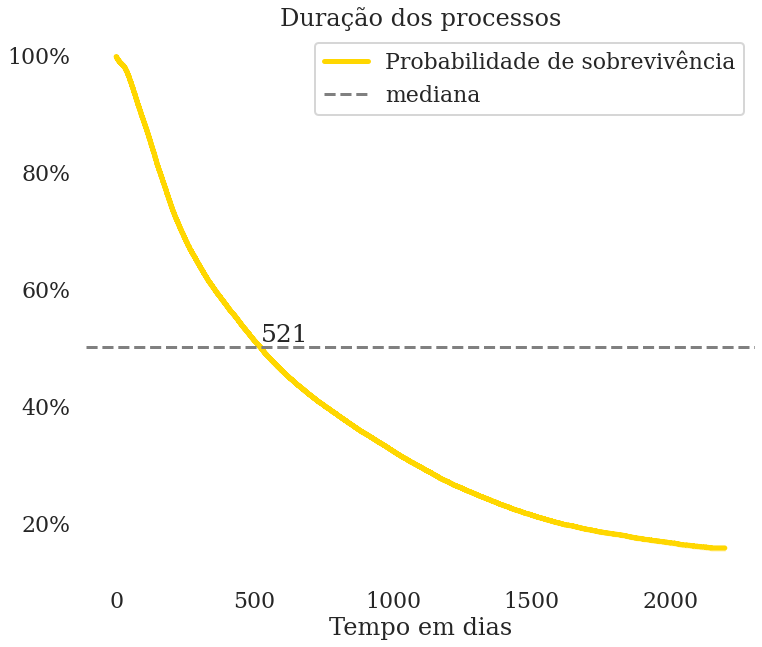

In [45]:
ax = kmf.plot(label="Probabilidade de sobrevivência", color="gold", lw=5)

ax.axhline(y=0.5, label="mediana", linewidth=None, linestyle="--", color='grey')
ax.yaxis.set_major_formatter(ticks_percentuais)
ax.set(title="Duração dos processos",
       xlabel="Tempo em dias")
ax.legend()
ax.text(x=522, y=0.51, s="521", size=25)

print(f"Duração mediana dos processos: {kmf.median_survival_time_:0.0f} dias")

## 3.2 Comparativo por competência

In [46]:
dados_sobrevivencia["comp"].value_counts()

Cível (Art. 164 LOJE-PB)                               33983
Juizado Especial Cível (Art. 201 LOJE-PB)              32107
Fazenda Pública (Art. 165 LOJE-PB)                     18549
Execução Fiscal Municipal (Art. 166 LOJE-PB)            6591
Feitos Especiais (Art. 169 LOJE-PB)                     4028
Sucessões (Art. 170 LOJE-PB)                            2293
Execução Fiscal Estadual (Art. 166 LOJE-PB)             2156
Juizado Especial da Fazenda Pública (Lei 12.153/09)      229
Infância e Juventude (Civel)                              44
Execução Fiscal Federal                                    1
Name: comp, dtype: int64

Desconsideraremos os processos com as competências "Infância e Juventude (Civel)" e "Execução Fiscal Federal", dado o baixíssimo volume.

In [47]:
competencias = list(dados_sobrevivencia["comp"].unique())
competencias.remove("Infância e Juventude (Civel)")
competencias.remove("Execução Fiscal Federal")
print(*competencias, sep = ", ")

Feitos Especiais (Art. 169 LOJE-PB), Cível (Art. 164 LOJE-PB), Juizado Especial Cível (Art. 201 LOJE-PB), Sucessões (Art. 170 LOJE-PB), Fazenda Pública (Art. 165 LOJE-PB), Execução Fiscal Municipal (Art. 166 LOJE-PB), Execução Fiscal Estadual (Art. 166 LOJE-PB), Juizado Especial da Fazenda Pública (Lei 12.153/09)


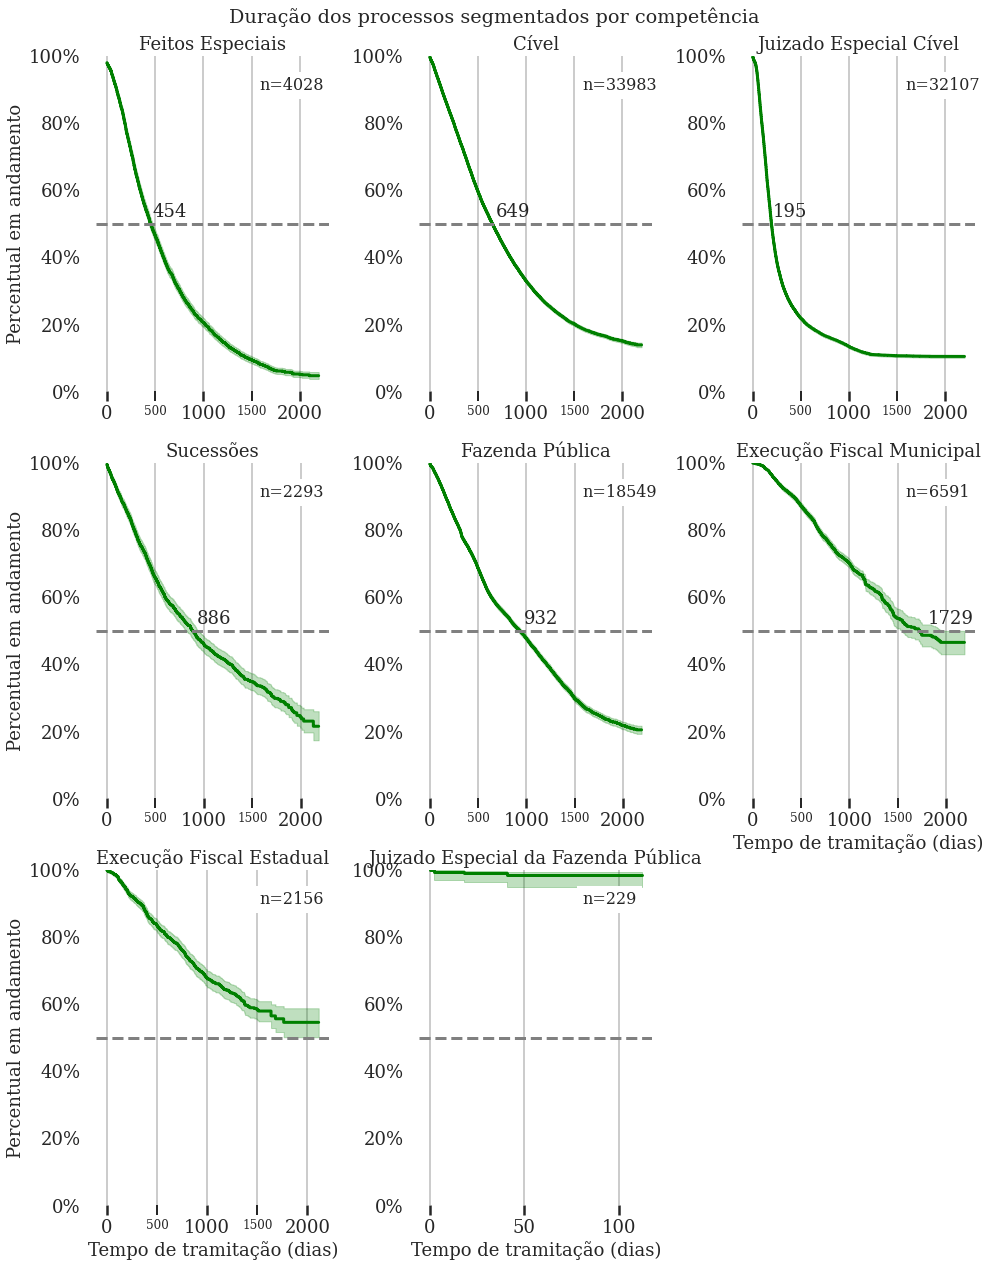

In [48]:
fig, axes = plt.subplots(3, 3, figsize=(14, 18))
flattened_axes = axes.flatten()
fig.delaxes(flattened_axes[-1])

fig.suptitle("Duração dos processos segmentados por competência")


for i, competencia in enumerate(competencias):
    ax = flattened_axes[i]

    kmf.fit(durations=dados_sobrevivencia.loc[dados_sobrevivencia["comp"] == competencia, "duracao_dias"],
            event_observed=dados_sobrevivencia.loc[dados_sobrevivencia["comp"] == competencia, "finalizado"])
    kmf.plot(ax=ax, legend=False, color = 'green')

    # Ticks percentuais
    ax.yaxis.set_major_formatter(ticks_percentuais)
    # Título dos subplots
    ax.set(title=re.sub(" \(.*", "", competencia),
           ylim=(0, 1))

    # marcação da mediana
    ax.axhline(y=0.5, label="mediana", linewidth=None,
               linestyle="--", color='grey')

    # calcula e mostra tempo mediano
    duracao_mediana = kmf.median_survival_time_
    if duracao_mediana != np.Infinity:
        ax.text(x=duracao_mediana * 1.05,
                y=0.52,
                s=f"{duracao_mediana:.0f}",
                fontsize=18)

    # calcula e exibe N da amostra
    total_processos = (dados_sobrevivencia["comp"] == competencia).sum()
    ax.text(x=0.7, y=0.9, s=f"n={total_processos:.0f}",
            transform=ax.transAxes, backgroundcolor="white")

    ax.xaxis.set_minor_locator(MultipleLocator(500))
    ax.tick_params(axis='x', which='both', bottom=True,
                   length=10, direction="out")
    ax.xaxis.set_minor_formatter(FormatStrFormatter("%.0f"))
    for label in ax.get_xticklabels(minor=True):
        label.set_fontsize(12)
    ax.xaxis.grid(True, "both")
    # ax.set_xticklabels()

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)

    if i % 3 == 0:
        ax.set_ylabel("Percentual em andamento")

    if i in (5, 6, 7):
        ax.set_xlabel("Tempo de tramitação (dias)")
    else:
        ax.set_xlabel("")

# ajusta sobreposições
plt.tight_layout()


In [49]:
type(kmf.median_survival_time_)
# kmf.survival_function_.index[-2]


numpy.float64

## 3.3 Comparativo de processos com análise de liminar x sem análise de liminar

In [50]:
com_analise_liminar = dados_sobrevivencia.loc[dados_sobrevivencia["analise_liminar"]]
sem_analise_liminar = dados_sobrevivencia.loc[~dados_sobrevivencia["analise_liminar"]]

print(f"Total com análise de liminar: {com_analise_liminar.shape[0]}",
 f"Total sem análise de liminar: {sem_analise_liminar.shape[0]}", sep="\n")

Total com análise de liminar: 4659
Total sem análise de liminar: 95322


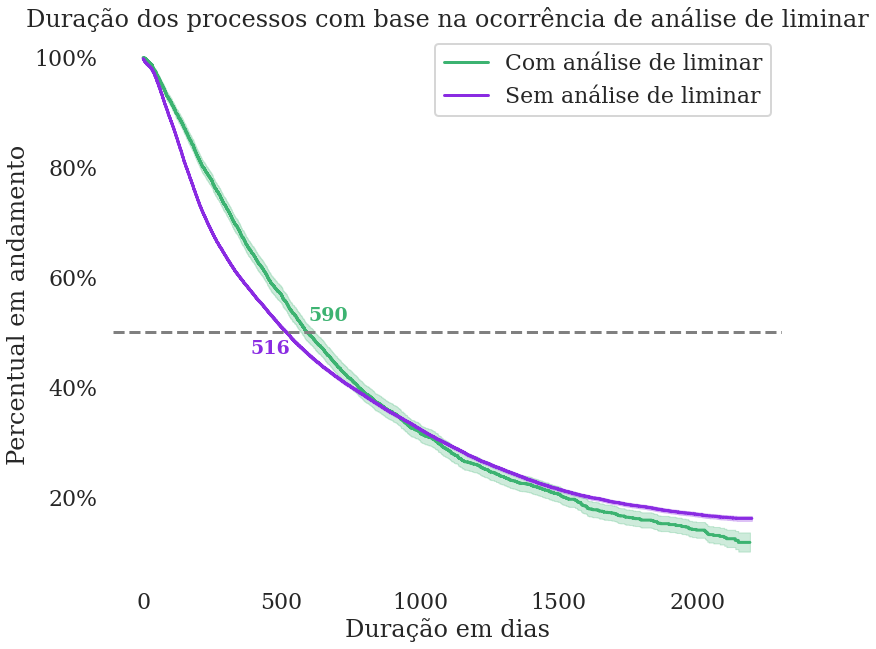

In [51]:
kmf.fit(durations=com_analise_liminar["duracao_dias"],
        event_observed=com_analise_liminar["finalizado"],
        label="Com análise de liminar")
color_com_liminar = "mediumseagreen"
ax = kmf.plot_survival_function(color = color_com_liminar)
duracao_mediana = kmf.median_survival_time_
ax.text(x=duracao_mediana * 1.01,
        y=0.52,
        s=f"{duracao_mediana:.0f}",
        fontsize=19,
        color = color_com_liminar,
        weight = "bold")


kmf.fit(durations=sem_analise_liminar["duracao_dias"],
        event_observed=sem_analise_liminar["finalizado"],
        label="Sem análise de liminar")
color_sem_liminar = "blueviolet"
kmf.plot_survival_function(ax=ax, color = color_sem_liminar)
duracao_mediana = kmf.median_survival_time_
ax.text(x=duracao_mediana * 0.75,
        y=0.46,
        s=f"{duracao_mediana:.0f}",
        fontsize=19,
        color = color_sem_liminar,
        weight = "bold")


ax.axhline(y=0.5, label="mediana", linewidth=None,
           linestyle="--", color='grey')
ax.set(title="Duração dos processos com base na ocorrência de análise de liminar",
       xlabel="Duração em dias", ylabel="Percentual em andamento")



# Ticks percentuais
ax.yaxis.set_major_formatter(ticks_percentuais)


In [52]:
test_results = logrank_test(durations_A=com_analise_liminar["duracao_dias"], durations_B=sem_analise_liminar["duracao_dias"],
             event_observed_A=com_analise_liminar["finalizado"], event_observed_B=sem_analise_liminar["finalizado"],
             alpha=0.95)
test_results.print_summary()

c:\Users\Jancer\anaconda3\envs\tjpb\lib\site-packages\lifelines\statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           9.93 <0.005      9.26

In [53]:
# test_results.p_value

## 3.4 Comparativo de processos com liminar concedida x denegada

In [54]:
com_liminar_concedida = dados_sobrevivencia.loc[dados_sobrevivencia["liminar_concedida_denegada"].fillna(False)]
com_liminar_denegada = dados_sobrevivencia.loc[dados_sobrevivencia["liminar_concedida_denegada"].fillna(True) == False]

print(f"Total com liminar concedida: {com_liminar_concedida.shape[0]}",
 f"Total com liminar denegada: {com_liminar_denegada.shape[0]}", sep="\n")

Total com liminar concedida: 3799
Total com liminar denegada: 860


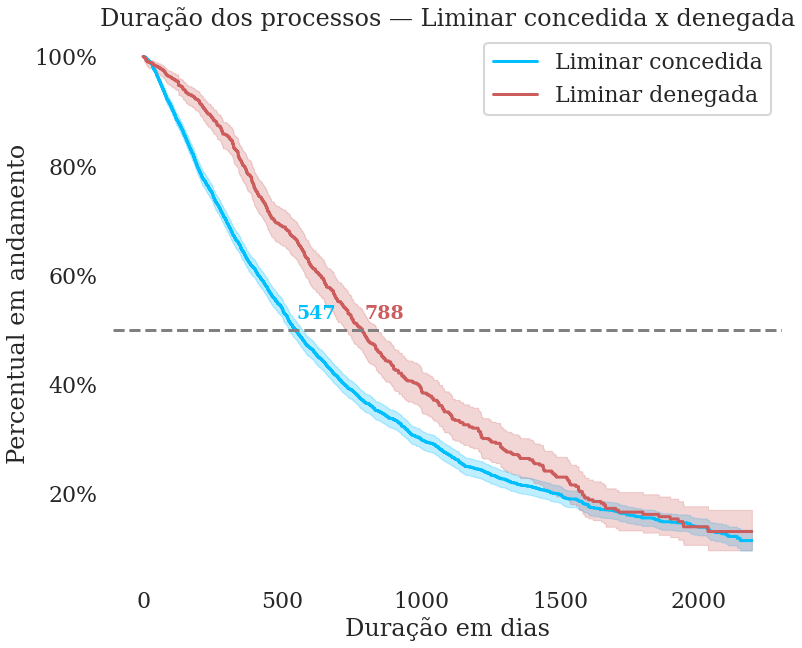

In [55]:
kmf.fit(durations=com_liminar_concedida["duracao_dias"],
        event_observed=com_liminar_concedida["finalizado"],
        label="Liminar concedida")
color_com_liminar = "deepskyblue"
ax = kmf.plot_survival_function(color = color_com_liminar)
duracao_mediana = kmf.median_survival_time_
ax.text(x=duracao_mediana * 1.01,
        y=0.52,
        s=f"{duracao_mediana:.0f}",
        fontsize=19,
        color = color_com_liminar,
        weight = "bold")


kmf.fit(durations=com_liminar_denegada["duracao_dias"],
        event_observed=com_liminar_denegada["finalizado"],
        label="Liminar denegada")
color_sem_liminar = "indianred"
kmf.plot_survival_function(ax=ax, color = color_sem_liminar)
duracao_mediana = kmf.median_survival_time_
ax.text(x=duracao_mediana * 1.01,
        y=0.52,
        s=f"{duracao_mediana:.0f}",
        fontsize=19,
        color = color_sem_liminar,
        weight = "bold")


ax.axhline(y=0.5, label="mediana", linewidth=None,
           linestyle="--", color='grey')
ax.set(title="Duração dos processos — Liminar concedida x denegada",
       xlabel="Duração em dias", ylabel="Percentual em andamento")



# Ticks percentuais
ax.yaxis.set_major_formatter(ticks_percentuais)


In [56]:
test_results = logrank_test(durations_A=com_liminar_concedida["duracao_dias"], durations_B=com_liminar_denegada["duracao_dias"],
             event_observed_A=com_liminar_concedida["finalizado"], event_observed_B=com_liminar_denegada["finalizado"],
             alpha=0.95)
# print(test_results.p_value)
test_results.print_summary()

c:\Users\Jancer\anaconda3\envs\tjpb\lib\site-packages\lifelines\statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          35.03 <0.005     28.20